In [7]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mmtbx.f_model
import mmtbx.model
import cctbx.crystal
import cctbx.xray
from iotbx import pdb
import cctbx.miller
import iotbx
from scitbx.array_family import flex

sys.path.append(str(Path(Path.home(), "Documents/xray/src")))
from miller_ops import get_f_obs, get_flags



In [9]:
all_f_obs = list()
all_flags = list()
for cif_file in [Path("../data/cifs/native_2_0.cif"), Path("../data/cifs/native_2_1.cif")]:
    f_obs = get_f_obs(
        cif_file
    )
    flags = get_flags(
        cif_file
    )
    all_f_obs.append(f_obs)
    all_flags.append(flags)


In [15]:
flags.size()

31995

In [16]:
free_vals = list()
for f_obs_arr in f_obs_arrays:
    matched_f_obs = list()
    for i in range(len(f_obs_arr.data())):
        if flags_array.data()[i]:
            matched_f_obs.append(f_obs_arr.data()[i])

    free_vals.append(matched_f_obs)




(0.0, 100.0)

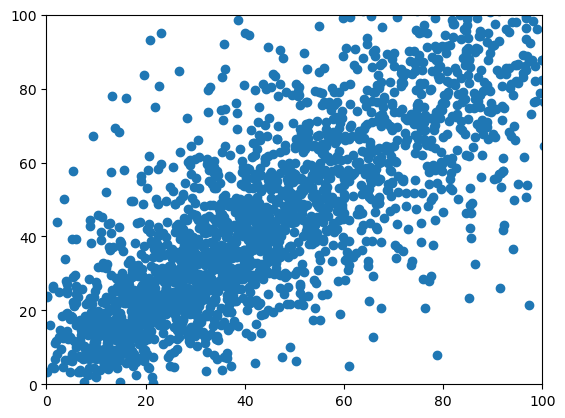

In [17]:
plt.plot(free_vals[0], free_vals[1], 'o')
plt.xlim(0, 100)
plt.ylim(0, 100)

In [21]:
crystal_symmetry = cctbx.xray.crystal.symmetry(
    unit_cell=(42.419, 51.741, 88.639, 90.000, 90.000, 90.000),
    space_group_symbol="P 21 21 21"
)
pdb_file = Path("../../../data/pdbs/3k0m/3k0m_clean.pdb")

pdb_inp = pdb.input(file_name=str(pdb_file))
h = pdb_inp.construct_hierarchy()

xray_structure = h.extract_xray_structure(crystal_symmetry=crystal_symmetry)

n_scatt = xray_structure.scatterers().size()
print(n_scatt)


2464


In [48]:
all_f_models = list()
for i in range(len(all_f_obs)):
    f_obs = all_f_obs[i]
    free_flags = all_flags[i]

    xray_structure.scatterers().flags_set_grads(
        state=False
    )
    xray_structure.scatterers().flags_set_grad_site(
        iselection=xray_structure.all_selection().iselection()
    )
    xray_structure.scatterers().flags_set_grad_occupancy(
        iselection=xray_structure.all_selection().iselection()
    )

    f_model_manager = mmtbx.f_model.manager(
        xray_structure=xray_structure,
        f_obs=f_obs,
        r_free_flags=free_flags,
        target_name="ml"
    )

    fmodels = mmtbx.fmodels(fmodel_xray=f_model_manager)
    fmodels.update_xray_structure(
        xray_structure=xray_structure,
        update_f_calc=True
    )

    f_model_manager.update_all_scales(
        apply_scale_k1_to_f_obs=True,
        remove_outliers=False
    )

    fmodels = mmtbx.fmodels(fmodel_xray=f_model_manager)
    fmodels.update_xray_structure(
        xray_structure=xray_structure,
        update_f_calc=True
    )

    all_f_models.append(f_model_manager.f_model())

    print(f_model_manager.r_free())
    print(f_model_manager.r_work())
    print(f_model_manager.show())

    # score = fmodels_target_and_gradients.target()
    # grads = fmodels_target_and_gradients.gradients()


0.27837349929684957
0.2684654455500526

 ======================== Statistics in resolution bins ======================== 

Total model structure factor:
  F_model = k_total * (F_calc + k_mask * F_mask)

    k_total = k_isotropic * k_anisotropic
   Resolution    Compl Nwork Nfree R_work    <Fobs>  <Fmodel> kiso   kani kmask
 44.685-11.080  100.00    89    11 0.1891  1226.273  1212.412 1.020 1.000 0.960
 11.054-8.737   100.00    92     9 0.2803   425.142   405.994 1.333 1.000 0.800
  8.721-6.913   100.00   169    20 0.3364   303.245   286.719 1.165 1.000 0.749
  6.903-5.460   100.00   330    36 0.3071   228.553   219.831 1.039 1.000 0.730
  5.457-4.315   100.00   647    72 0.2038   318.357   316.331 1.010 1.000 0.570
  4.312-3.409   100.00  1292   143 0.2309   283.777   280.338 0.966 1.000 0.312
  3.409-2.695   100.00  2566   286 0.2510   186.443   183.097 0.945 1.000 0.210
  2.694-2.129   100.00  5110   567 0.2707   121.259   118.265 0.929 1.000 0.000
  2.129-1.683   100.00 10221  1136 

In [47]:
f_model_manager.show()


 ======================== Statistics in resolution bins ======================== 

Total model structure factor:
  F_model = k_total * (F_calc + k_mask * F_mask)

    k_total = k_isotropic * k_anisotropic
   Resolution    Compl Nwork Nfree R_work    <Fobs>  <Fmodel> kiso   kani kmask
 44.685-11.080  100.00    89    11 0.2201  1241.975  1255.053 1.289 1.000 0.863
 11.054-8.737   100.00    92     9 0.2994   424.620   402.659 1.326 1.000 0.806
  8.721-6.913   100.00   169    20 0.3369   304.713   280.598 1.164 1.000 0.733
  6.903-5.460   100.00   330    36 0.2964   227.433   216.579 1.034 1.000 0.700
  5.457-4.315   100.00   647    72 0.1990   321.208   316.747 1.037 1.000 0.620
  4.312-3.409   100.00  1292   143 0.2139   284.538   278.476 0.965 1.000 0.460
  3.409-2.695   100.00  2566   286 0.2392   186.410   180.374 0.941 1.000 0.260
  2.694-2.129   100.00  5110   567 0.2674   121.583   116.987 0.931 1.000 0.000
  2.129-1.683   100.00 10221  1136 0.2892    66.792    63.579 0.907 1.000 

In [46]:
dir(f_model_manager)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data_type',
 '_f_obs',
 '_get_real_map',
 '_get_structure_factor_gradients_w',
 '_get_target_name',
 '_hl_coeffs',
 '_i_obs',
 '_origin',
 '_r_factor',
 '_r_free_flags',
 '_set_twin_set',
 '_structure_factor_gradients_w',
 '_target_memory',
 '_target_name',
 '_update_mask_params',
 '_wilson_b',
 'alpha_beta',
 'alpha_beta_cache',
 'alpha_beta_params',
 'alpha_beta_t',
 'alpha_beta_w',
 'alpha_beta_with_restrained_n_calc',
 'anomalous_map',
 'apply_scale_k1_to_f_obs',
 'arrays',
 'b_cart',
 'b_h',
 'b_sol',
 'bin_selections',
 'bins',
 'check_f_mask_all_zero',
 'checksum',
 'classical_dm